<h1 align="center"><a href="https://github.com/sborquez/gerumo/">*</a> GeRUMo - Gamma-ray Events Reconstructor with Uncertain models</h1>

<h2 align="center">Evaluate</h2>

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/2f/Cta_concept.jpg" width="30%" alt="icon"></img>
</center>



## Setup

The first step is to sync this notebook with Google Drive, and change directory to gerumo repository.

In [1]:
%cd "/content/drive/My Drive/Projects/gerumo"
!ls

/content/drive/My Drive/Projects/gerumo
docs		gerumo	 notebooks  Pipfile.lock  setup.py  train
enviroment.yml	LICENSE  Pipfile    README.md	  tests


## Load Gerumo and extra modules.

In [2]:
from gerumo import *

import logging
import time
from os import path

import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from sklearn.metrics import r2_score
import json
from tqdm.notebook import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Configuration file

In [0]:
#config_file = "/content/drive/My Drive/Projects/gerumo/train/config/colab/alt_az/umonna_assembler_colab.json"
config_file = "/content/drive/My Drive/Projects/gerumo/train/config/colab/energy/umonna_assembler_colab.json"

In [8]:
print(f"Loading config from: {config_file}")
with open(config_file) as cfg_file:
    config = json.load(cfg_file)

# Model
model_name = config["model_name"]

# Dataset Parameters
output_folder = config["output_folder"]
replace_folder_test = config["replace_folder_test"]
test_events_csv    = config["test_events_csv"]
test_telescope_csv = config["test_telescope_csv"]

# Input and Target Parameters 
telescopes = config["telescopes"]
min_observations = config["min_observations"]
input_image_mode = config["input_image_mode"]
input_image_mask = config["input_image_mask"]
input_features = config["input_features"]
targets = config["targets"]
target_mode = "lineal"
target_shapes = config["target_shapes"]
target_domains = config["target_domains"]
target_resolutions = get_resolution(targets, target_domains, target_shapes)

# Prepare Generator target_mode_config 
target_mode_config = {
    "target_shapes":      tuple([target_shapes[target]      for target in targets]),
    "target_domains":     tuple([target_domains[target]     for target in targets]),
    "target_resolutions": tuple([target_resolutions[target] for target in targets])
}
if target_mode == "probability_map":
    target_sigmas = config["target_sigmas"]
    target_mode_config["target_sigmas"] = tuple([target_sigmas[target] for target in targets])

# Evaluation Parameters
save_plots = config["save_plots"]
save_predictions = config["save_predictions"]

Loading config from: /content/drive/My Drive/Projects/gerumo/train/config/colab/energy/umonna_assembler_colab.json


In [9]:
import pprint
pprint.pprint(config, width=1)

{'input_features': ['x',
                    'y'],
 'input_image_mask': True,
 'input_image_mode': 'simple-shift',
 'min_observations': [0,
                      0,
                      0],
 'model_name': 'UMONNA_V2_ENERGY',
 'output_folder': '/content/drive/Shared '
                  'drives/umonna/data/output',
 'replace_folder_test': '/content/drive/Shared '
                        'drives/umonna/data/data/raw/Test',
 'save_plots': True,
 'save_predictions': True,
 'target_domains': {'alt': [1.05,
                            1.382],
                    'az': [-0.52,
                           0.52],
                    'log10_mc_energy': [-2.351,
                                        2.47]},
 'target_mode': 'lineal',
 'target_shapes': {'alt': 81,
                   'az': 81,
                   'log10_mc_energy': 81},
 'target_sigmas': {'alt': 0.002,
                   'az': 0.002,
                   'log10_mc_energy': 0.002},
 'targets': ['log10_mc_energy'],
 'telescopes': {'LST_

## Load Dataset

In [0]:
# Prepare datasets
test_dataset = load_dataset(test_events_csv, test_telescope_csv, replace_folder_test)
test_dataset = aggregate_dataset(test_dataset, az=True, log10_mc_energy=True)
test_dataset = filter_dataset(test_dataset, telescopes, min_observations, target_domains)

# Preprocessing pipes
preprocess_input_pipes = []
preprocess_output_pipes = []

## Data Generator

In [0]:
# Generators
batch_size = 64
telescope_types = [t for t in telescopes.keys() if telescopes[t] is not None]
test_generator = AssemblerGenerator(test_dataset, telescope_types,
                                    batch_size, 
                                    input_image_mode=input_image_mode, 
                                    input_image_mask=input_image_mask, 
                                    input_features=input_features,
                                    targets=targets,
                                    target_mode=target_mode, 
                                    target_mode_config=target_mode_config,
                                    preprocess_input_pipes=preprocess_input_pipes,
                                    preprocess_output_pipes=preprocess_output_pipes,
                                    include_event_id=True
)

# Small test sample
sample_events = np.random.choice(test_dataset.event_unique_id.unique(), 256)
sample_dataset = test_dataset[test_dataset.event_unique_id.isin(sample_events)]

sample_generator = AssemblerGenerator(sample_dataset, telescope_types,
                                    batch_size, 
                                    input_image_mode=input_image_mode, 
                                    input_image_mask=input_image_mask, 
                                    input_features=input_features,
                                    targets=targets,
                                    target_mode="lineal", 
                                    target_mode_config=target_mode_config,
                                    preprocess_input_pipes=preprocess_input_pipes,
                                    preprocess_output_pipes=preprocess_output_pipes,
                                    include_event_id=True
)

### Generator sample

In [8]:
# Debug: Check if test dataset is loadable
for i in tqdm(range(len(test_generator))):
  _ = test_generator[i]

# Debug: Check if sample dataset is loadable
for i in tqdm(range(len(sample_generator))):
  _ = sample_generator[i]

## Load Models

In [11]:
sst = telescopes["SST1M_DigiCam"]
mst = telescopes["MST_FlashCam"]
lst = telescopes["LST_LSTCam"]
telescopes

{'LST_LSTCam': '/content/drive/Shared drives/umonna/data/models/energy/small/UMONNA_UNIT_LST_V2_ENERGY_LST_LSTCam_crossentropy_e010_3.1496.h5',
 'MST_FlashCam': '/content/drive/Shared drives/umonna/data/models/energy/small/UMONNA_UNIT_MST_V2_ENERGY_MST_FlashCam_crossentropy_e015_3.4590.h5',
 'SST1M_DigiCam': '/content/drive/Shared drives/umonna/data/models/energy/small/UMONNA_UNIT_SST_V2_ENERGY_SST1M_DigiCam_crossentropy_e004_3.3022.h5'}

In [0]:
umonna_assembler = Umonna(sst1m_model_or_path=sst,
                mst_model_or_path=mst,
                lst_model_or_path=lst,
                targets=targets, target_shapes=target_mode_config["target_shapes"],
                target_domains=target_mode_config["target_domains"],
                target_resolutions=target_mode_config["target_resolutions"],
                assembler_mode="normalized_product",
                point_estimation_mode="expected_value"
)


## Model Unit Predictions

## Assembler Predictions


In [0]:
# Prepare targets points
targets_values = []
event_ids = []
for x, t in sample_generator:
    event_ids.extend([x_i["event_id"] for x_i in x])
    targets_values.append(t)
targets_values = np.array(targets_values).reshape((-1, len(targets)))

In [0]:
# Predictions
predictions = umonna_assembler.predict(sample_generator)
predictions_points = umonna_assembler.predict_point(sample_generator)

In [0]:
target_domains = umonna_assembler.target_domains
target_resolutions = umonna_assembler.target_resolutions
targets = umonna_assembler.targets

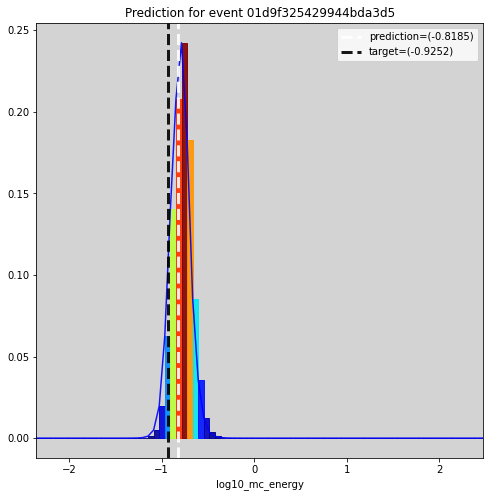

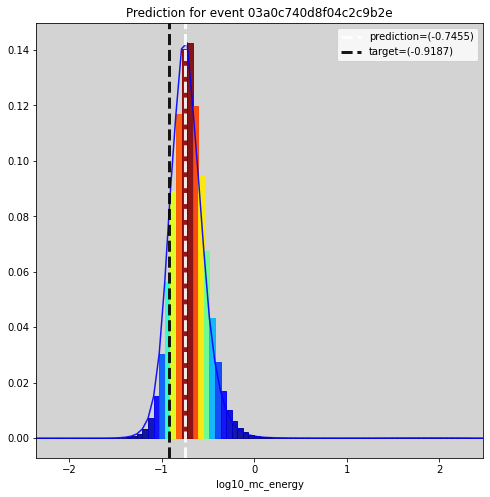

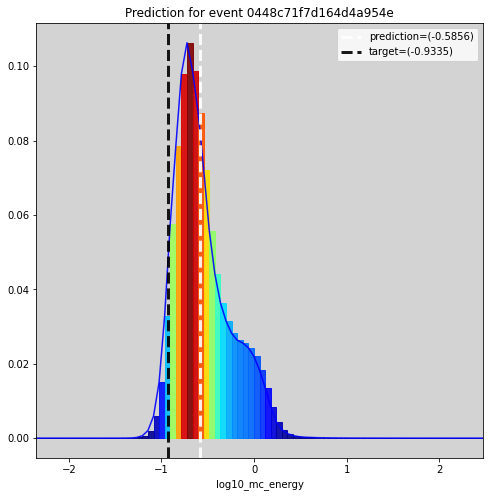

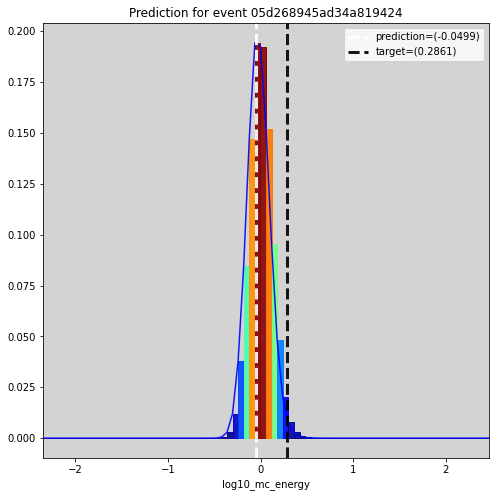

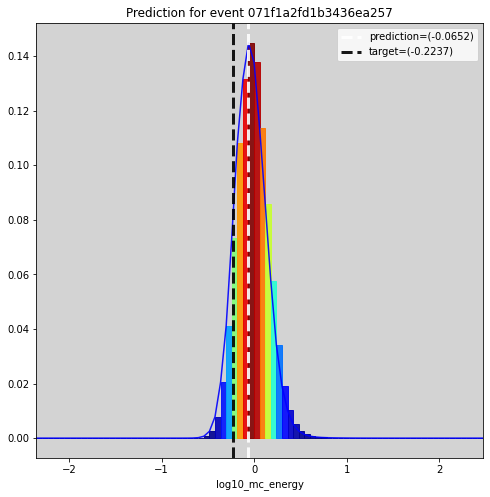

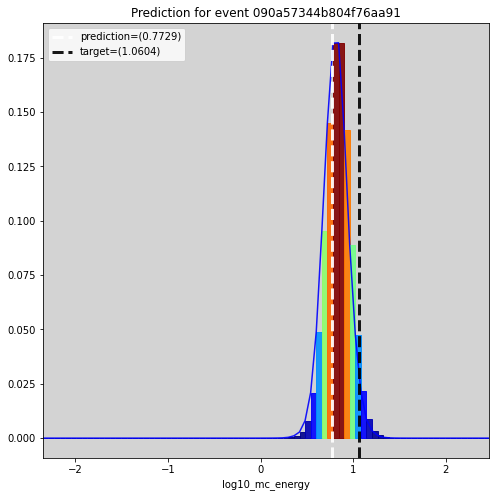

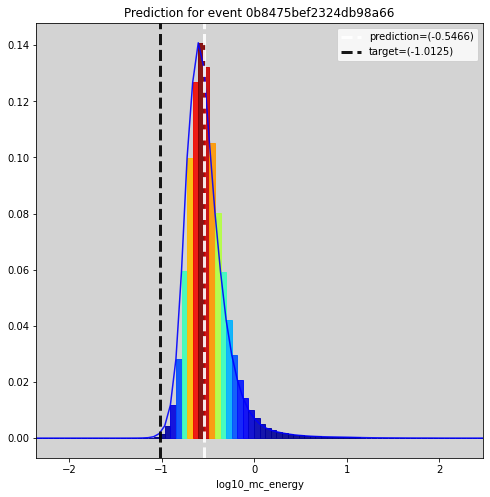

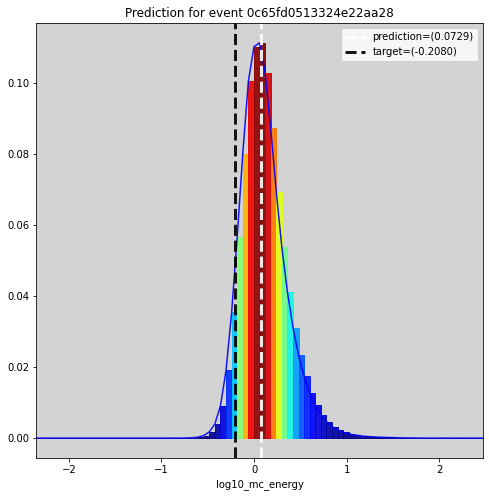

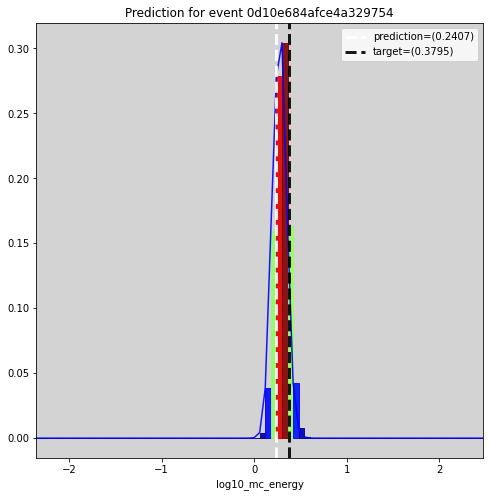

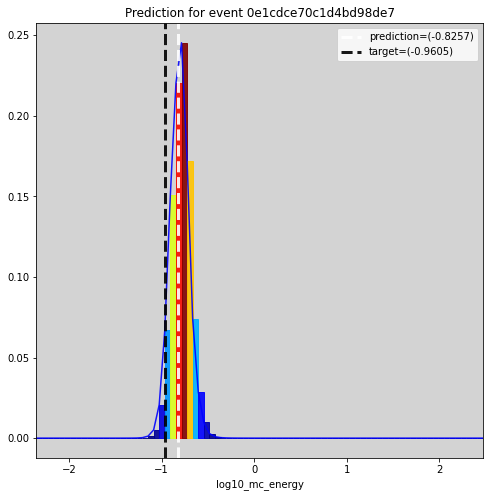

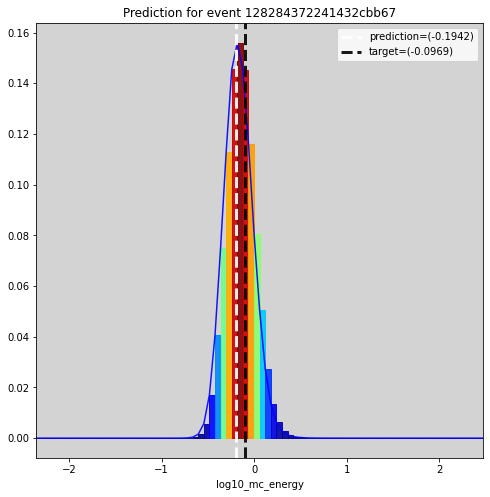

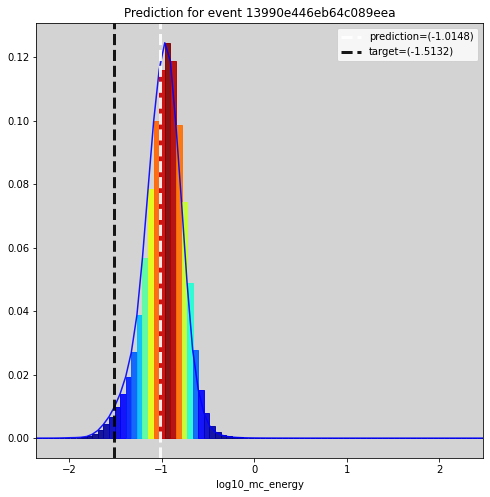

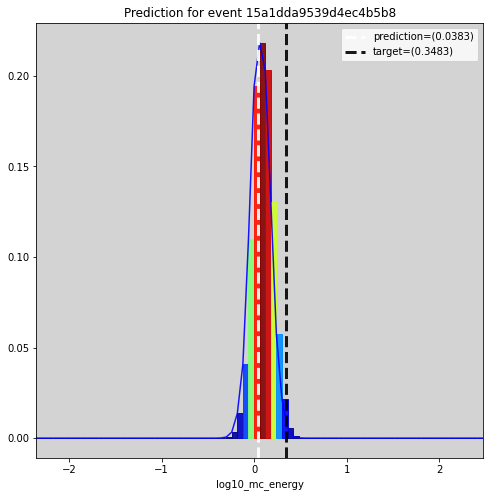

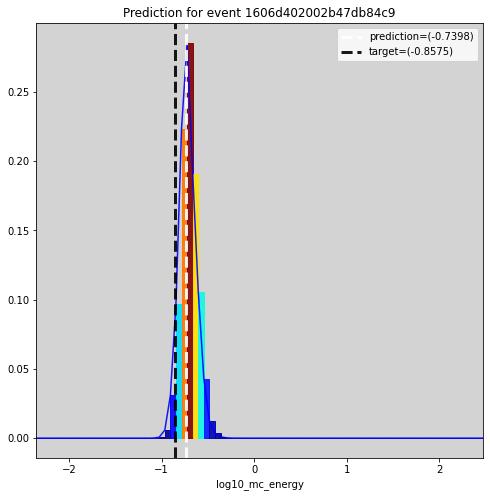

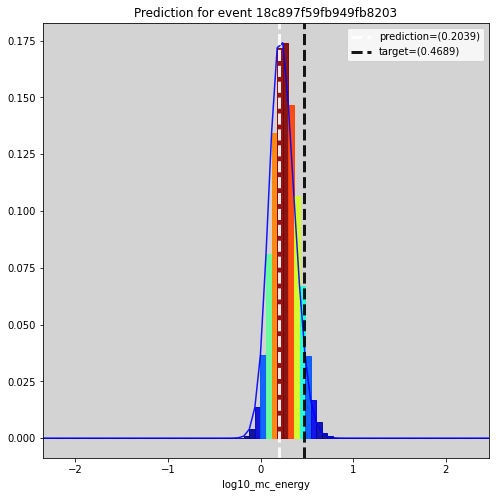

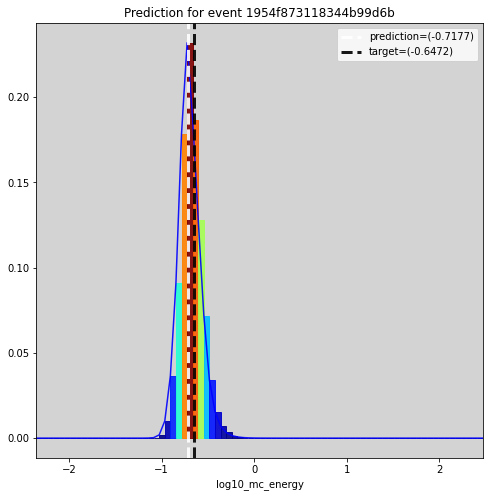

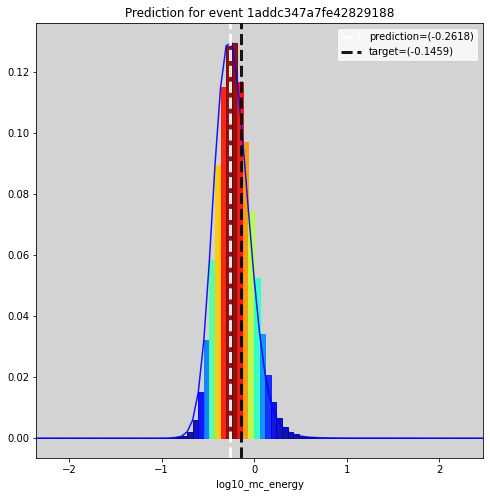

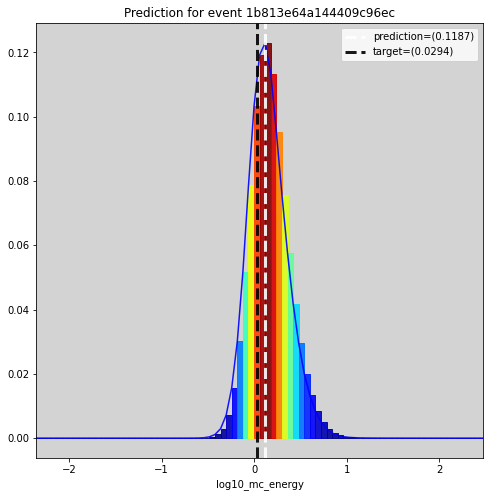

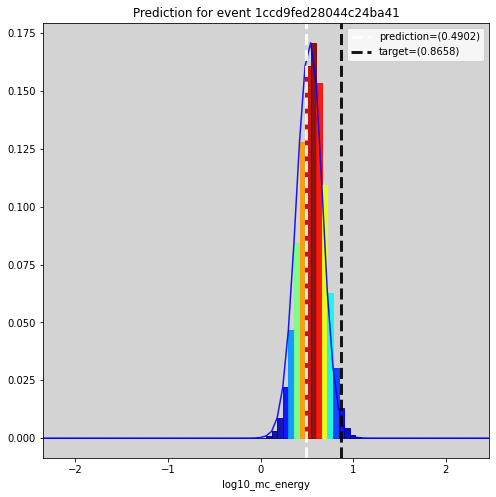

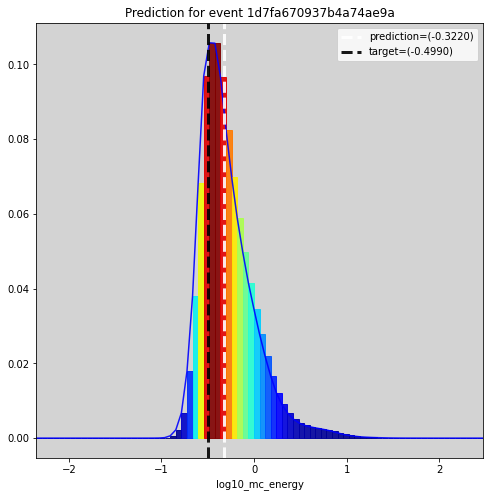

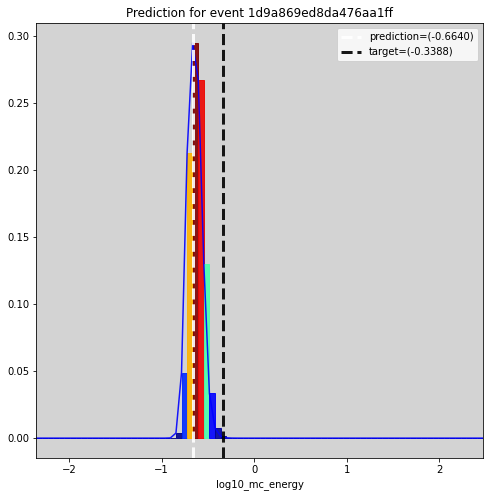

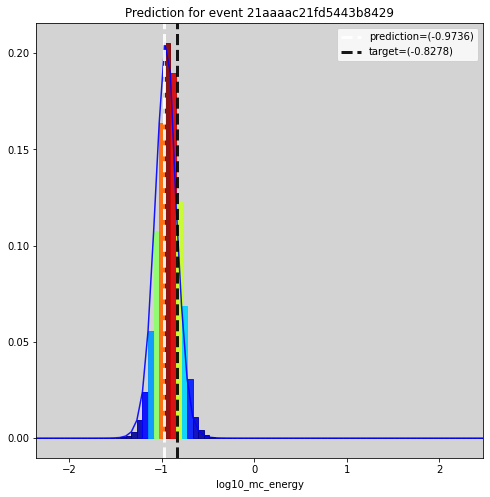

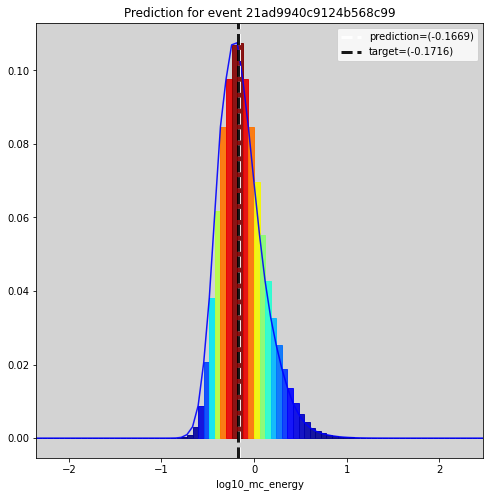

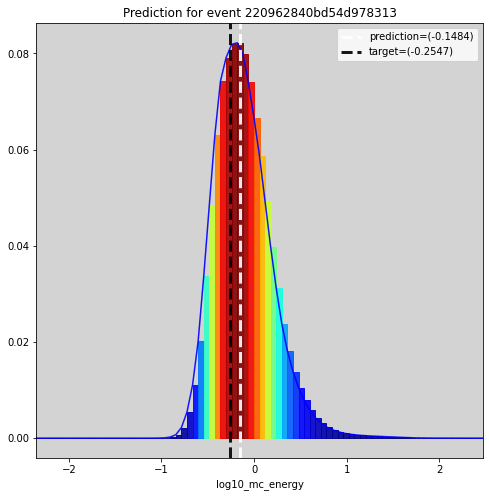

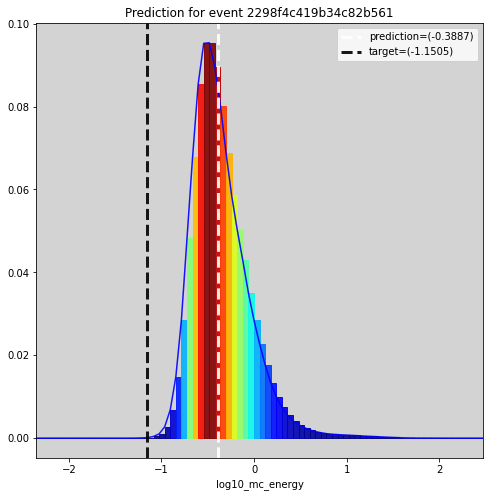

In [124]:
i = 0
for prediction, prediction_point, target_point, event_id in zip(predictions, predictions_points, targets_values, event_ids):
    plot_assembler_prediction(prediction, prediction_point, targets, target_domains, target_resolutions, event_id, target_point)
    i+=1
    if i == 25: break

## Assembler Evaluation

In [0]:
scores, df = umonna_assembler.evaluate(sample_generator, return_predictions=True)
#scores, df = umonna_assembler.evaluate(test_generator, return_predictions=True)

In [0]:
def plot_regression_evaluation(evaluation_results, targets, scores, save_to=None):
    """
    Display regression metrics for the results of evaluate a assembler model.
    """

    n_targets = len(targets)
    # Create Figure and axis
    fig, axs = plt.subplots(n_targets, 3, figsize=(19, n_targets*6))
    
    # Style
    plt.suptitle("Targets Regression")

    # For each target, generate two plots
    for i, (target, score) in enumerate(zip(targets, scores)):
        # Target and prediction values
        prediction_points = evaluation_results[f"pred_{target}"]
        targets_points = evaluation_results[f"true_{target}"]
        # Show regression
        ax_r = axs[i][0] if n_targets > 1 else axs[0]
        show_regression_identity(prediction_points, targets_points, score, target, ax_r)
        # Show error
        ax_e = axs[i][1] if n_targets > 1 else axs[1]
        show_residual_error(prediction_points, targets_points, score, target, ax_e)
        # Show error distribution
        ax_d = axs[i][2] if n_targets > 1 else axs[2]
        show_residual_error_distribution(prediction_points, targets_points, score, target, vertical=True, axis=ax_d)

    # Save or Show
    if save_to is not None:
        plt.savefig(save_to)
    else:
        plt.show()

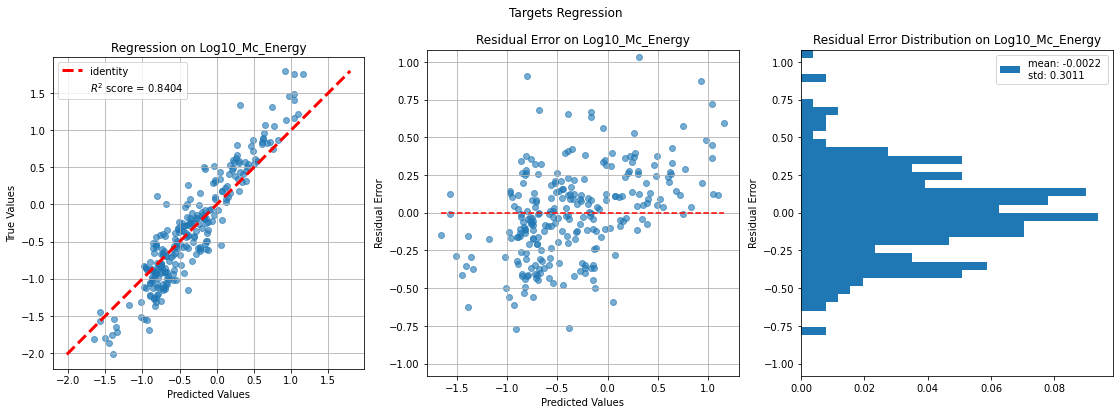

In [46]:
if scores is None:
    df_ = df.dropna()
    #scores = r2_score(df_[["true_alt", "true_az"]], df_[["pred_alt", "pred_az"]], multioutput="raw_values")
    scores = r2_score(df_[["true_log10_mc_energy"]], df_[["pred_log10_mc_energy"]], multioutput="raw_values")
plot_regression_evaluation(df, targets, scores)

In [0]:
df.to_csv("/content/drive/My Drive/Projects/gerumo/notebooks/evaluation.csv")